In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/punkt/punkt/portuguese.pickle
/kaggle/input/punkt/punkt/greek.pickle
/kaggle/input/punkt/punkt/estonian.pickle
/kaggle/input/punkt/punkt/czech.pickle
/kaggle/input/punkt/punkt/danish.pickle
/kaggle/input/punkt/punkt/README
/kaggle/input/punkt/punkt/english.pickle
/kaggle/input/punkt/punkt/italian.pickle
/kaggle/input/punkt/punkt/german.pickle
/kaggle/input/punkt/punkt/polish.pickle
/kaggle/input/punkt/punkt/french.pickle
/kaggle/input/punkt/punkt/norwegian.pickle
/kaggle/input/punkt/punkt/swedish.pickle
/kaggle/input/punkt/punkt/dutch.pickle
/kaggle/input/punkt/punkt/slovene.pickle
/kaggle/input/punkt/punkt/turkish.pickle


# ReadNet: A Hierarchical Transformer Framework for Web Article Readability Analysis

The   [ReadNet](https://arxiv.org/abs/2103.04083) was published in 2021 march, it  proposed a new and comprehensive framework which uses a hierarchical self-attention model to analyze document readability.It has been evaluated over three widely-used benchmark datasets against several strong baseline approaches. Experimental results showed that the  proposed method achieves the state-of-the-art performance on estimating the readability for various web articles and literature.

In this notebook we'll try to use ReadNet for calculating the readability value of given samples. Since readnet has achived a far better acuuracy than BERT on the Text Classification on WeeBit (Readability Assessment) , we'll see whether the same improved performance is reflected in CommonLit Readability Competition.


### Importing Required libraries

In [2]:
import torch
import numpy as np
from torch import Tensor, nn, tensor
import math
import pandas as pd
import csv
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from pathlib import Path
from fastai.vision.all import *
from fastai.text.all import *

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


![Readnet ](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-45439-5_3/MediaObjects/492459_1_En_3_Fig1_HTML.png)

## Defining the layers 
The layers from the representation of readnet is implemented below.

### Multi-Head Attention

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, masked):
        super().__init__()
        assert d_model % num_heads == 0, "num_heads must evenly chunk d_model"
        self.num_heads = num_heads
        self.wq = nn.Linear(d_model, d_model, bias=False)  # QQ what if bias=True?
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.masked = masked
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v):
        qs = self.wq(q).chunk(self.num_heads, dim=2)
        ks = self.wk(k).chunk(self.num_heads, dim=2)
        vs = self.wv(v).chunk(self.num_heads, dim=2)
        outs = []
        # TODO Use einsum instead of for loop
        for qi, ki, vi in zip(qs, ks, vs):
            attns = qi.bmm(ki.transpose(1, 2)) / (ki.shape[2] ** 0.5)
            if self.masked:
                attns = attns.tril()  # Zero out upper triangle so it can't look ahead
            attns = self.softmax(attns)
            outs.append(attns.bmm(vi))
        return torch.cat(outs, dim=2)

### Add & Norm

In [4]:
class AddNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x1, x2):
        return self.ln(x1+x2)


### Feed Forward

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.l1 = nn.Linear(d_model, d_model)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(d_model, d_model)
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

### Atention 

In [6]:
class AttentionAggregation(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, 1, bias=False)

    def forward(self, x):  # (b, s, m)
        attns = self.query(x).softmax(dim=1)  # (b, s, 1)
        enc = torch.bmm(attns.transpose(1, 2), x)  # (b, 1, m)
        return enc.squeeze(1)

### Readnet 

In [7]:
class ReadNetBlock(nn.Module):
    def __init__(self, d_model, n_heads, n_blocks, n_feats, n_out):
        super().__init__()
        self.blocks = nn.Sequential(*[EncoderBlock(d_model=d_model, num_heads=n_heads) for _ in range(n_blocks)])
        self.lin_tanh = LinTanh(d_model=d_model)
        self.attn_agg = AttentionAggregation(d_model=d_model)
        self.lin_feat_concat = LinFeatConcat(d_model=d_model, n_feats=n_feats, n_out=n_out)

    def forward(self, x, feats):  # (b, s, m), (b, f)
        x = pos_encode(x)
        x = self.blocks(x)
        x = self.lin_tanh(x)
        x = self.attn_agg(x)
        return self.lin_feat_concat(x, feats)
    
    
class ReadNet(nn.Module):
    def __init__(self, embed, d_model, n_heads, n_blocks, n_feats_sent, n_feats_doc):
        super().__init__()
        self.embed = embed
        self.sent_block = ReadNetBlock(
            d_model=d_model, n_heads=n_heads, n_blocks=n_blocks, n_feats=n_feats_sent, n_out=d_model
        )
        self.doc_block = ReadNetBlock(
            d_model=d_model, n_heads=n_heads, n_blocks=n_blocks, n_feats=n_feats_doc, n_out=d_model + n_feats_doc
        )
        self.head = nn.Sequential(
            nn.Linear(d_model + n_feats_doc, 1),
        )

    def forward(self, x, feats_sent=None, feats_doc=None):  # (b, d, s) tokens, (b, d, n_f_s), (b, n_f_d)
        if feats_sent is None: feats_sent = Tensor([])
        if feats_doc is None: feats_doc = Tensor([])
        if x.is_cuda:
            feats_sent = feats_sent.cuda()
            feats_doc = feats_doc.cuda()
        #print(len(x))
        #print(x.shape)
        #print(x)
        
        x = self.embed(x)
        b, d, s, m = x.shape
        x = x.reshape(b * d, s, m)
        sents_enc = self.sent_block(x, feats_sent.reshape(b * d, -1))  # (b*d, m)
        docs = sents_enc.reshape(b, d, m)
        docs_enc = self.doc_block(docs, feats_doc)
        out = self.head(docs_enc)
        return out.squeeze(1)


### Positional Encoding and Tokenizing Layers

In [8]:



# Make sure to have your glove embeddings stored here
root_dir = '../input/glove-embeddings'


## MODEL CODE ##










def pos_encode(x):
    pos, dim = torch.meshgrid(torch.arange(x.shape[1]), torch.arange(x.shape[2]))
    dim = 2 * (dim // 2)
    enc_base = pos/(10_000**(dim / x.shape[2]))
    addition = torch.zeros_like(x)
    for d in range(x.shape[2]):
        enc_func = torch.sin if d % 2 == 0 else torch.cos
        addition[:,:,d] = enc_func(enc_base[:,d])
    if x.is_cuda:
        addition = addition.cuda()
    #print(x+addition)
    return x + addition


class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads, masked=False)
        self.an1 = AddNorm(d_model)
        self.ff = FeedForward(d_model)
        self.an2 = AddNorm(d_model)

    def forward(self, x):
        x = self.an1(x, self.mha(q=x, k=x, v=x))
        return self.an2(x, self.ff(x))





class LinTanh(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.lin = nn.Linear(d_model, d_model)
        self.tanh = nn.Tanh()

    def forward(self, x):
        return self.tanh(self.lin(x))


class LinFeatConcat(nn.Module):
    def __init__(self, d_model, n_feats, n_out):
        super().__init__()
        self.lin = nn.Linear(d_model + n_feats, n_out, bias=False)  # TODO what if True?

    def forward(self, x, feats):
        return self.lin(torch.cat([x, feats], dim=1))





class GloveEmbedding(nn.Module):
    def __init__(self, num):
        super().__init__()
        # Make embedding
        self.embed = nn.Embedding(400_000 + 1, num)
        emb_w = pd.read_csv(
            root_dir +'/'+ f'glove.6B.{num}d.txt', header=None, sep=" ", quoting=csv.QUOTE_NONE
        ).values[:, 1:].astype('float64')
        emb_w = Tensor(emb_w)
        emb_w = torch.cat([emb_w, torch.zeros(1, num)], dim=0)
        self.embed.weight = nn.Parameter(emb_w)

    def forward(self, x):
        return self.embed(x.to(torch.long))




## DATA PREPARATION ##

class GloveTokenizer:
    def __init__(self, num):
        words = pd.read_csv(
            root_dir + '/'+ f'glove.6B.{num}d.txt', header=None, sep=" ", quoting=csv.QUOTE_NONE, usecols=[0]
        ).values
        words = [word[0] for word in words]
        self.word2idx = {w: i for i, w in enumerate(words)}

    def __call__(self, sent):
        toks = [self.word2idx.get(w.lower()) for w in word_tokenize(sent)]
        return [self.unk_token if t is None else t for t in toks]

    @property
    def unk_token(self):
        return 400_000  # We appended this to the end of the embedding to return all zeros

    @property
    def pad_token(self):
        return self.unk_token  # Seems that this is the best option for GLOVE


def prepare_txts(txts, tokenizer):
    # Input: (bs,) str, Output: (bs, max_doc_len, max_sent_len)
    # We choose to elongate all docs and sentences to the max rather than truncate some of them
    # TODO: Do this better later:
    # (1) Truncate smartly (if there is one very long outlier sentence or doc)
    # (2) Group together docs of similar lengths (in terms of num_sents)
    docs = [[tokenizer(sent) for sent in sent_tokenize(txt)] for txt in txts]
    # pkl_save(root_dir/"doc_lens", pd.Series([len(doc) for doc in docs]))
    max_doc_len = max([len(doc) for doc in docs])
    docs = [doc + [[]] * (max_doc_len - len(doc)) for doc in docs]
    # pkl_save(root_dir/"sent_lens", pd.Series([len(sent) for doc in docs for sent in doc]))
    max_sent_len = max([len(sent) for doc in docs for sent in doc])
    docs = [[s + [tokenizer.pad_token] * (max_sent_len - len(s)) for s in doc] for doc in docs]
    return Tensor(docs)


def prepare_txts_cut(txts, tokenizer, max_doc_len=18, max_sent_len=49):
    docs = [[tokenizer(sent)[:max_sent_len] for sent in sent_tokenize(txt)[:max_doc_len]] for txt in txts]
    docs = [doc + [[]] * (max_doc_len - len(doc)) for doc in docs]
    docs = [[s + [tokenizer.pad_token] * (max_sent_len - len(s)) for s in doc] for doc in docs]
    return Tensor(docs)






## Tokenization and embedding

The golve tokenizer is used to tokenize and then glove embeddings of corresponding words are givenas input to the model , we'll be using glove 200 d vector since it gave the best results for us.

In [9]:
## TRAIN ## (using fastai)

tokenizer = GloveTokenizer(200)
embed = GloveEmbedding(200)

def get_splits(data):
  num = len(data)
  idx = list(range(num))
  random.seed(42)
  random.shuffle(idx)
  split = int(num*0.75)
  return idx[:split], idx[split:]


def get_dls(bs,path):
  data = pd.read_csv(path)
  txts = data.excerpt.tolist()
  x = prepare_txts_cut(txts, tokenizer)
  y = data.target.tolist()

  ds = TfmdLists(
      zip(x, y),
      tfms=[],
      splits=get_splits(data),
  )
  #print(ds)
  dls = ds.dataloaders(batch_size=bs)
  print(dls)
  return dls


## Model
The model is loaded into cuda using the get model function and we define the parameters here.
Note: d_model must be a multiple of n_heads.

In [10]:
def get_model():
    readnet = ReadNet(
        embed=embed,
        d_model=200,
        n_heads=4,
        n_blocks=6,
        n_feats_sent=0,
        n_feats_doc=0,
    )
    readnet = readnet.cuda()

    # Automatically freeze the embedding. We should not be learning this
    for p in readnet.embed.parameters():
        p.requires_grad = False

    return readnet

## Training
Train the model with the given 

epoch,train_loss,valid_loss,time
0,1.326133,1.121905,00:13
1,1.124877,1.071498,00:13
2,1.093344,1.069204,00:13
3,1.083428,1.090949,00:12
4,1.008086,0.827456,00:13
5,0.873732,0.805431,00:13
6,0.756587,0.732548,00:13
7,0.684190,0.667925,00:13
8,0.658320,0.634575,00:13
9,0.623669,0.614982,00:12


Better model found at epoch 0 with valid_loss value: 1.1219053268432617.
Better model found at epoch 1 with valid_loss value: 1.0714982748031616.
Better model found at epoch 2 with valid_loss value: 1.069204330444336.
Better model found at epoch 4 with valid_loss value: 0.8274561166763306.
Better model found at epoch 5 with valid_loss value: 0.8054313063621521.
Better model found at epoch 6 with valid_loss value: 0.7325479984283447.
Better model found at epoch 7 with valid_loss value: 0.6679248213768005.
Better model found at epoch 8 with valid_loss value: 0.6345745921134949.
Better model found at epoch 9 with valid_loss value: 0.6149822473526001.
Better model found at epoch 10 with valid_loss value: 0.6075802445411682.
Better model found at epoch 11 with valid_loss value: 0.5672332644462585.
Better model found at epoch 12 with valid_loss value: 0.5420349836349487.
Better model found at epoch 13 with valid_loss value: 0.5280389189720154.
Better model found at epoch 15 with valid_loss v

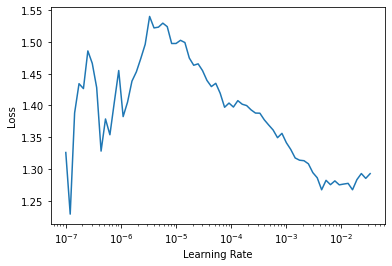

In [11]:

learn = Learner(dls=get_dls(32,path="../input/commonlitreadabilityprize/train.csv"), model=get_model(), loss_func=MSELossFlat())
learn.summary()
learn.lr_find()
learn.fit_one_cycle(20, 3e-5,cbs=SaveModelCallback())

In [12]:
import gc

In [13]:
#del learn
gc.collect()

12657

In [14]:
test_df= pd.read_csv('../input/commonlitreadabilityprize/test.csv')

In [15]:
test_df

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,"My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.\n""I am certai..."
1,f0953f0a5,NaN,NaN,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played ""King and Queen."" Dotty said she wished they could ever remember to bring their nipperkins, for in that case the milk would taste a great deal more like nectar. The ""nipperkins"" were a pair of handled cups which the children supposed to be silver, and which they always used at table.\nDotty knew she was doing wrong every time she played ""King and Queen."" She knew the milk was not hers, but Mrs. Gray's; still she said to herself, ..."
2,0df072751,NaN,NaN,"It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage.\nIt was strictly a family gathering, yet the room was quite full. Mr. Dinsmore was there with his wife, his daughter Elsie and her children, Edward and Zoe, Elsie Leland with her husband and babe, Violet Raymond with her husband's two little girls, Lulu and Grace, and lastly Rosie and Walter.\nEverybody had a kindly greeting for the captain, and Violet's bright face grew still brighter as she made room for him on the sofa by her side.\n""We were beginni..."
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,"Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell cycle.\n In eukaryotes, there are two distinct types of cell division: a vegetative division, whereby each daughter cell is genetically identical to the parent cell (mitosis), and a reproductive cell division, whereby the number of chromosomes in the daughter cells is reduced by half, to produce haploid gametes (meiosis). \nMeiosis results in four haploid daughter cells by undergoing one round of DNA replication followed by two divisions: homolo..."
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,"Debugging is the process of finding and resolving of defects that prevent correct operation of computer software or a system. Debugging tends to be harder when various subsystems are tightly coupled, as changes in one may cause bugs to emerge in another.\nNumerous books have been written about debugging, as it involves numerous aspects, including interactive debugging, control flow, integration testing, log files, monitoring (application, system), memory dumps, profiling, Statistical Process Control, and special design tactics to improve detection while simplifying changes. The terms ""bug""..."
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at a totally different example that has a lot to do with transitivity but nothing to do with rationality. A combination of choices is rational if an observer can deduce someone else's preferences (that is, learn what that person likes best, medium, and least) just by observing his choices. Suppose I put your friends Adam and Ben side-by-side and I see that Adam is taller than Ben. Then I put Ben and Charlie side-by-side and I see that Ben is taller than Charlie. Can you tell me who is taller, Adam or Charlie? Adam, of course. How do we know? We si..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,"Milka and John are playing in the garden. Her little sister is playing too. 

In [16]:
def prepare_txts_pred(txts, tokenizer, max_doc_len=18, max_sent_len=49):
    docs = [[tokenizer(sent)[:max_sent_len] for sent in sent_tokenize(txt)[:max_doc_len]] for txt in txts]
    docs = [doc + [[]] * (max_doc_len - len(doc)) for doc in docs]
    docs = [[s + [tokenizer.pad_token] * (max_sent_len - len(s)) for s in doc] for doc in docs]
    return Tensor(docs)

In [17]:
txts = test_df.excerpt.tolist()
x = prepare_txts_pred(txts, tokenizer)


In [18]:
model = get_model()

In [19]:
del learn
gc.collect()

9885

## Load Model

Load the trained model for prediction on test dataset

In [20]:
model.load_state_dict(torch.load('./models/model.pth'))

<All keys matched successfully>

In [21]:
device = "cuda:0"
model = model.to(device)

In [22]:
len(x)

7

In [23]:
pred_batch_List=[]

In [24]:
last = 0

## Batching
Batch the inputs during prediction as well since the test set during submission run is a much larger dataset.

In [25]:
for i in range(0,len(x)-4,4):
    pred_batch_List.append((x[i:i+4]))
    last = i + 4
    torch.cuda.empty_cache()
pred_batch_List.append(x[last:len(x)])

In [26]:
predictions = []

## Predicting

In [27]:
for x in pred_batch_List:
    with torch.no_grad():
        a= x.to(device)
        y_temp = model(a)
        y_temp = y_temp.cpu()
        predictions.append(y_temp)
    del y_temp
    del a
    gc.collect()
    

In [28]:
import operator as op

In [29]:
 torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  323437 KB |    1900 MB |    8634 GB |    8633 GB |\n|       from large pool |  313344 KB |    1857 MB |    8384 GB |    8384 GB |\n|       from small pool |   10093 KB |      70 MB |     249 GB |     249 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  323437 KB |    1900 MB |    8634 GB |    8633 GB |\n|       from large pool |  313344 KB |    1857 MB |

In [30]:
len(pred_batch_List)

2

In [31]:
y=torch.cat(predictions)

In [32]:
len(y)

7

In [33]:
y = y.cpu()

In [34]:
preds = y.detach().numpy()

In [35]:
preds

array([-0.45213774, -0.18718731, -0.3138944 , -1.8271401 , -1.7936956 ,
       -1.4590604 ,  0.10502657], dtype=float32)

In [36]:
list(preds)

[-0.45213774,
 -0.18718731,
 -0.3138944,
 -1.8271401,
 -1.7936956,
 -1.4590604,
 0.10502657]

In [37]:
test_df

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,"My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.\n""I am certai..."
1,f0953f0a5,NaN,NaN,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played ""King and Queen."" Dotty said she wished they could ever remember to bring their nipperkins, for in that case the milk would taste a great deal more like nectar. The ""nipperkins"" were a pair of handled cups which the children supposed to be silver, and which they always used at table.\nDotty knew she was doing wrong every time she played ""King and Queen."" She knew the milk was not hers, but Mrs. Gray's; still she said to herself, ..."
2,0df072751,NaN,NaN,"It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage.\nIt was strictly a family gathering, yet the room was quite full. Mr. Dinsmore was there with his wife, his daughter Elsie and her children, Edward and Zoe, Elsie Leland with her husband and babe, Violet Raymond with her husband's two little girls, Lulu and Grace, and lastly Rosie and Walter.\nEverybody had a kindly greeting for the captain, and Violet's bright face grew still brighter as she made room for him on the sofa by her side.\n""We were beginni..."
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,"Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell cycle.\n In eukaryotes, there are two distinct types of cell division: a vegetative division, whereby each daughter cell is genetically identical to the parent cell (mitosis), and a reproductive cell division, whereby the number of chromosomes in the daughter cells is reduced by half, to produce haploid gametes (meiosis). \nMeiosis results in four haploid daughter cells by undergoing one round of DNA replication followed by two divisions: homolo..."
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,"Debugging is the process of finding and resolving of defects that prevent correct operation of computer software or a system. Debugging tends to be harder when various subsystems are tightly coupled, as changes in one may cause bugs to emerge in another.\nNumerous books have been written about debugging, as it involves numerous aspects, including interactive debugging, control flow, integration testing, log files, monitoring (application, system), memory dumps, profiling, Statistical Process Control, and special design tactics to improve detection while simplifying changes. The terms ""bug""..."
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at a totally different example that has a lot to do with transitivity but nothing to do with rationality. A combination of choices is rational if an observer can deduce someone else's preferences (that is, learn what that person likes best, medium, and least) just by observing his choices. Suppose I put your friends Adam and Ben side-by-side and I see that Adam is taller than Ben. Then I put Ben and Charlie side-by-side and I see that Ben is taller than Charlie. Can you tell me who is taller, Adam or Charlie? Adam, of course. How do we know? We si..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,"Milka and John are playing in the garden. Her little sister is playing too. 

In [38]:
sub = test_df

In [39]:
samp= pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [40]:
samp

,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0
5,12537fe78,0.0
6,965e592c0,0.0


In [41]:
sub["target"] = preds

In [42]:
sub.drop(["url_legal","license","excerpt"],axis=1,inplace=True)

In [43]:
sub

,id,target
0,c0f722661,-0.452138
1,f0953f0a5,-0.187187
2,0df072751,-0.313894
3,04caf4e0c,-1.827140
4,0e63f8bea,-1.793696
5,12537fe78,-1.459060
6,965e592c0,0.105027


## submission
save the predictions to sub and save it to submission.csv for prediction

In [44]:
sub.to_csv("submission.csv",index=False)

## Credits

* This notebook uses the readnet implementation from https://github.com/vdefont/readnet.
* Readnet Paper : https://arxiv.org/abs/2103.04083


## Results 
Although the validation score was 0.47 , The submission score was not 0.674 .The model has not generalized well, I have observed this with other models too, do share your thoughts on this in the comments.